In [79]:
from os import walk

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='notebook', color_codes=True)

import numpy as np
import pandas as pd

from stats import sample_from_posterior

from pymc3_models import durw_fit, edhmm_fit

In [2]:
# get the file names
f = []
for (dirpath, dirnames, filenames) in walk('data'):
    f.extend(filenames)
    break
f = np.sort(f)[1:]

# set parameters
n_subs = len(f)  # number of subjects

T = 160  # total number of trials
last = -35  # set the time point for the post-reversal phase

# input variables for inference
inp = np.zeros((T, n_subs, 3), dtype = np.int64)

# failed trials
nans = np.zeros((T, n_subs), dtype = bool)

# format data
for i,file in enumerate(f):
    sub, _ = file.split(sep='.')
    sub = int(sub[-2:])
    data = pd.read_csv(dirpath + '/' + file)
    start = data['S'][0] 
    data = data.loc[:,'A':'R']

    # change choice labels from (1,2) to (0,1)  
    if start == 1:
        data['A'] -= 1
    else:
        # reverse labels (1,2) to (1,0) if the initial best choice was 2
        data['A'] = 2 - data['A']
      
    data['R'][data['R']==-1] = 0  # map choice outcomes from {-1,1} to {0,1}
    data['T'] = 1  # set the switch variable to one (it is set to zero only for nan trials)
    nans[:,i] = data.isnull().any(axis = 1)
    data[nans[:,i]] = 0
    data = data.astype(int)
    inp[:,i,:] = data.values

In [3]:
approx_durw = durw_fit(inp, nans, n_subs, last)

/mnt/data/miniconda/envs/ppls/lib/python3.8/site-packages/theano/gpuarray/dnn.py:184: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to a version >= v5 and <= v7.
  warnings.warn("Your cuDNN version is more recent than "


Finished [100%]: Average Loss = 783.42


In [4]:
# sample from posterior and estimate posterior predictive log-model evidence 
# for the trials excluded from model fitting
varnames = ['c0', 'beta', 'alpha', 'kappa', 'V0', 'G']
durw_sample, pplme, plike2 = sample_from_posterior(approx_durw, 
                                              varnames, 
                                              n_subs,
                                              inp[last:,:,0], 
                                              last)

# pplme -> provides posterior predictive log-model evidence 
# estimated over the 'last' trials for each participant 
# from 10000 predictive samples from the posterior

# plike2 -> provides response likelihood per trial over the 'last' trials, 
# averaged over 10000 predictive samples from the posterior

# uncomment for storing reults in HDF5 format
# store = pd.HDFStore('behavior_fits.h5')
# store['durw/trace'] = sample
# store['durw/pplme'] = pd.Series(pplme)
# store['durw/plike2'] = pd.DataFrame(plike2)
# store.close()

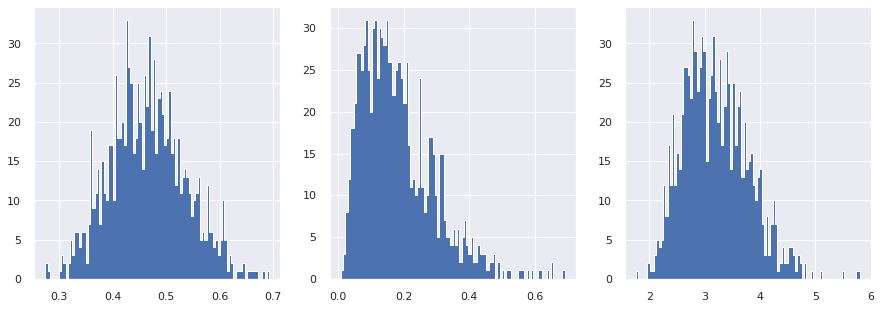

In [80]:
sidx = 0  # subject index - integer value between 0 and 21

fig, axes = plt.subplots(1, 3, figsize=(15, 5));
axes[0].hist(durw_sample['alpha__{}'.format(sidx)], bins=100, histtype='stepfilled');
axes[1].hist(durw_sample['kappa__{}'.format(sidx)], bins=100, histtype='stepfilled');
axes[2].hist(durw_sample['beta__{}'.format(sidx)], bins=100, histtype='stepfilled');

In [84]:
approx_edhmm = edhmm_fit(inp, nans, n_subs, last)

Finished [100%]: Average Loss = 840.51


In [85]:
varnames = ['c0', 'beta', 'delta', 'r', 'muA', 'muB', 'G']
edhmm_sample, pplme, plike2 = sample_from_posterior(approx_edhmm, 
                                              varnames, 
                                              n_subs,
                                              inp[last:,:,0], 
                                              last)

# uncomment for storing results in HDF5 format
# store = pd.HDFStore('behavior_fits.h5')
# store['edhmm/trace'] = sample
# store['edhmm/pplme'] = pd.Series(pplme)
# store['edhmm/plike2'] = pd.DataFrame(plike2)
# store.close()

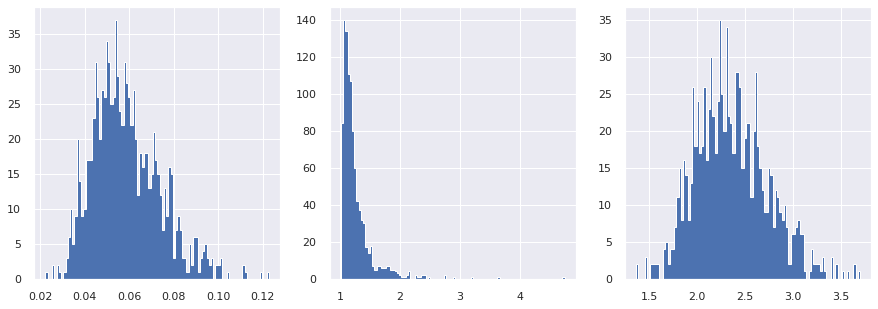

In [94]:
sidx = 0  # subject index - integer value between 0 and 21

fig, axes = plt.subplots(1, 3, figsize=(15, 5));
axes[0].hist(edhmm_sample['delta__{}'.format(sidx)], bins=100, histtype='stepfilled');
axes[1].hist(edhmm_sample['r__{}'.format(sidx)], bins=100, histtype='stepfilled');
axes[2].hist(edhmm_sample['beta__{}'.format(sidx)], bins=100, histtype='stepfilled');

# Posterior predictive checks and Bayesian chi-square

Given a sequence of responses $(r_1^n, \ldots, r_T^n)$ and a sample $s$ from the posterior over response probabilities $(p_{1, s}^n,\ldots,p_{T,s}^n)$ of the $n$th participant, we will define an approximate chi-square distributed variable as 

\begin{equation}
\chi_{s, n}^2(T)= \sum_{t=1}^{T} \frac{(r_t^n - p_{t,s}^n)^2}{p^n_{t,s} (1 - p^n_{t,s})}.
\end{equation}

Given $S$ samples from the posterior we obtained a posterior expected chi square with $T$ degrees of freedom as 
\begin{equation}
\bar{\chi}^2_n(T) = \frac{1}{S} \sum_{s=1}^S \chi_{s, n}^2(T)
\end{equation}

In practice, participants do not always provide a valid response. Hence, some of the trials have to be excluded from the estimate of $\bar{\chi}^2_n$. We will denote with $T_n$ the valid number of trails of the $n$th participant. Hence, a p-value of the fit to the behavioural data is obtained as 

\begin{equation}
\alpha_n = \Gamma_R\left( \frac{T_n}{2}, \frac{\bar{\chi}^2_n(T_n)}{2}\right)
\end{equation}
where $\Gamma_R(x, y)$ denotes regularised gamma function. Note that the Bayesian p-values are interpreted differently from their counterparts in statistics. If a model provides a good fit to the subject's data then  $\bar{\chi}^2_n(T)$ should be a likely sample from a $\chi^2_T$ distribution. Hence, we want to see p-values distributed around 0.5, as an evidence of good fit on a group level. In other words, the random variable $\bar{\chi}^2_n(T)$ should not be much smaller than a typical sample from the $\chi^2_T$ distribution (p-value < .05) nor much larger from a typical sample (p-value > .95).

In [87]:
from scipy.stats import chi2

def chi_square_stats(responses, probs, nans):
    
    valid_res = (~nans).astype(np.float)
    T_n = np.sum(~nans, 0)
    
    chi_2_vals = np.sum(valid_res * (responses - probs[..., -1])**2/np.prod(probs, -1), -2)
    
    p_values = chi2.cdf(chi_2_vals, T_n)
    
    return chi_2_vals.mean(0), p_values.mean(0), T_n

In [88]:
responses = inp[..., 0]
prob_durw = np.exp(durw_sample.loc[:, 'G__0_0_0':].values.reshape((-1,) + inp.shape[:-1] + (2,)))
prob_durw = prob_durw/prob_durw.sum(-1, keepdims=True)

prob_edhmm = np.exp(edhmm_sample.loc[:, 'G__0_0_0':].values.reshape((-1,) + inp.shape[:-1] + (2,)))
prob_edhmm = prob_edhmm/prob_edhmm.sum(-1, keepdims=True)

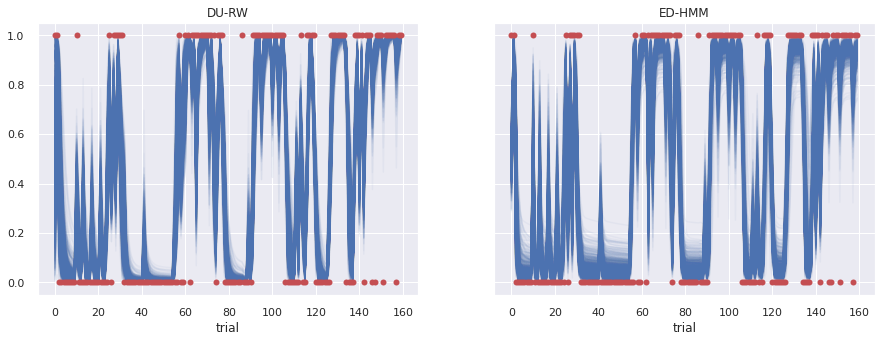

In [93]:
sidx = 0  # subject index

fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True, sharey=True)

axes[0].plot(prob_durw[..., sidx, -1].T, 'b', alpha=.05);
axes[0].plot(responses[:, sidx], 'ro');
axes[0].set_xlabel('trial');
axes[0].set_title('DU-RW');

axes[1].plot(prob_edhmm[..., sidx, -1].T, 'b', alpha=.05);
axes[1].plot(responses[:, sidx], 'ro');
axes[1].set_xlabel('trial');
axes[1].set_title('ED-HMM');

In [90]:
chi_2_durw, p_val_durw, Ts = chi_square_stats(responses, prob_durw, nans)
chi_2_edhmm, p_val_edhmm, Ts = chi_square_stats(responses, prob_edhmm, nans)

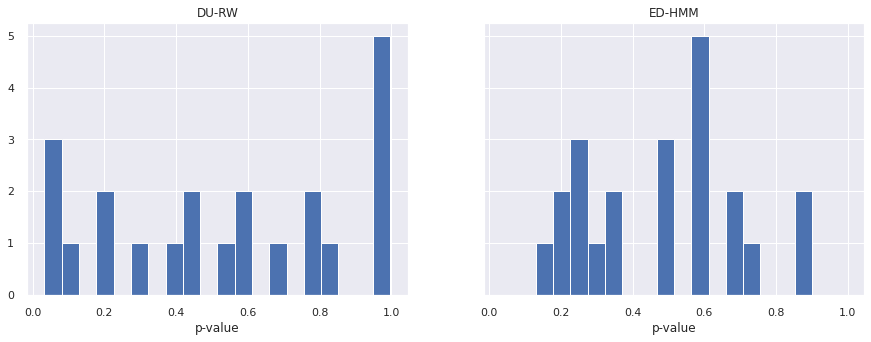

In [92]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True, sharey=True)

h = axes[0].hist(p_val_durw, bins=20);
axes[0].set_title('DU-RW')
axes[0].set_xlabel('p-value')

axes[1].hist(p_val_edhmm, bins=h[1])
axes[1].set_title('ED-HMM');
axes[1].set_xlabel('p-value');